<div align="center">

<h1> Cutiepy* </h1>

<h2> "Cu" stands for Quantum </h2>

<h2> "tie" stands for Tools </h2>

</div>
\* provisional name

# Solving Linear ODEs

You need two tools:

- Linear Algebra Libraries
- ODE solvers

## Numpy for LinAlg, Scipy for ODE solving

`zvode` solver used internally (1980s-1990s)

<table>
<tr><th>small (N&lt;20)</th><th>big (N&gt;100)</th><th>time dependent</th></tr>
<tr>
    <td>**Bad** - Severe overhead from python calls</td>
    <td>**Depends** - Оverhead from memory allocation (can be worked around)</td>
    <td>**Depends** - Any python function works, but python functions are very slow</td></tr>
</table>

In [ ]:
ts = np.linspace(...)
op = -1j*np.array(...)
f_prime = lambda t, state: op*(... t).dot(state)
state0_num = np.array(...)                                             
ode = scipy.integrate.ode(f_prime) ...
res = [state0_num]                                                              
for t in ts[1:]:                                                             
    ode.integrate(t)                                                            
    res.append(ode.y)                                                           
print(res[-1])

## Qutip

`zvode` (from Scipy) is used as well, but linear algebra goes to `cython` (most of the time)

<table>
<tr><th>small (N&lt;20)</th><th>big (N&gt;100)</th><th>time dependent</th></tr>
<tr>
    <td>**Good** - Noticeable overhead from cython/python calls</td>
    <td>**Good** - Minor overhead from cython/python calls</td>
    <td>**Bad** - Severely limited in scope and Inconsistent</td></tr>
</table>

In [ ]:
qutip.sesolve(H,init,ts,[])

if timedependent, `H` has to be:

- a python function for `sesolve`
- a list of lists (not tuples!?) for `mesolve` and `mcsolve`
- only recent versions try to bring some consistency to the interface (not yet done)

To run $\hat{H} = \hat{H}_0 + \operatorname{sin}(t)\hat{H}_1$ you write

In [ ]:
H = [H0, [H1, 'sin(t)']]

## Theano

- no built-in solver, but you can use (again) `zvode` (from Scipy)
- linear algebra is done internally with various optimizations (including in-place operations)
- bad sparse matrix support (getting better)

<table>
<tr><th>small (N&lt;20)</th><th>big (N&gt;100)</th><th>time dependent</th></tr>
<tr>
    <td>**Bad** - Severe overhead from theano/python calls</td>
    <td>**Good** - Minor overhead from theano/python calls</td>
    <td>**Great** - Symbolic optimizations (and in-place operations!)</td></tr>
</table>

## Summary

- Everybody uses the old `zvode` through `scipy` (if it has an ODE solver at all).
    - bad because if the slow detour through python
- Except `Theano` time dependence awkward if supported at all.

<table>
<tr><td></td><th>small (N&lt;20)</th><th>big (N&gt;100)</th><th>time dependent</th></tr>
<tr><th>Numpy/Scipy</th>
    <td>**Bad** - Severe overhead from python calls</td>
    <td>**Depends** - Оverhead from memory allocation (can be worked around)</td>
    <td>**Depends** - Any python function works, but python functions are very slow</td></tr>
<tr><th>Qutip</th>
    <td>**Good** - Noticeable overhead from cython/python calls</td>
    <td>**Good** - Minor overhead from cython/python calls</td>
    <td>**Bad** - Severely limited in scope and Inconsistent</td></tr>
<tr><th>Theano</th>
    <td>**Bad** - Severe overhead from theano/python calls</td>
    <td>**Good** - Minor overhead from theano/python calls</td>
    <td>**Great** - Symbolic optimizations (and in-place operations!)</td></tr>
<tr><th>Cutiepy</th>
    <td>?</td><td>?</td><td>?</td></tr>
</table>

# Cutiepy

Having short simple code was as important as making it fast.

- code generator (a simple one, <500 lines of code)
- symbolic algebra module (also a simple one, <1000 lines of code)

## Symbolic Expressions

In [1]:
from cutiepy import *
k = Ket('psi', 4)
k

'psi'

In [2]:
H = Operator('H', 4)
H

'H'

In [3]:
tensor(H,H)

TensorProd('H', 'H')

In [4]:
k2 = Ket('psi_2', [2,2])
k2

'psi_2'

In [5]:
sin(2*t)*H*k

Mul(sin(Mul(2, 't')), Dot('H', 'psi'))

## Numerical Content

In [6]:
import numpy as np
Ket('phi', 4, np.array([0,0,0,1], dtype=complex))

'phi'

## Built-in Operators (I should work a bit more on this)

In [7]:
sigmax()

'σ_x'

In [8]:
num(3)

'{n}_{3}'

## Lazy evaluation of expressions

In [9]:
expression = sigmax()*sigmay()
expression

Dot('σ_x', 'σ_y')

In [10]:
evalf(expression)

'abb0e9ed-8192-47fb-bdf5-14bd0c66eb47'

## Getting the numerical content

In [11]:
numerical(destroy(3))

array([[ 0.00000000+0.j,  1.00000000+0.j,  0.00000000+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j,  1.41421356+0.j],
       [ 0.00000000+0.j,  0.00000000+0.j,  0.00000000+0.j]])

## Code generation

- All these lazy expressions can be compiled to C (with cython) for very fast evaluation.
- Coupled to a modern ODE solver (in C, no python detour)
- Hidden behind the `sesolve`, `mesolve`, etc. intefaces

## Low Level Example

No need to worry about this in user code, but interesting if you want to help develop the library

In [12]:
y = Ket.anon(2)
op = -1j*num(2)
y_prime = op*y
y_prime

Mul(-1j, Dot('{n}_{2}', '906adb3b-5950-46a5-8cc3-492f5d50c854'))

In [13]:
f = generate_cython(y_prime, # Expression
                    NDArrayFunction(), # Type of compilation
                                       # (whether to couple to an ODE solver)
                    [y]) # Arguments for the function

In [14]:
codegen.DEBUG = True
cf = f.compiled()
codegen.DEBUG = False

In [15]:
arg = np.ones((2,1), dtype=complex)
arg

array([[ 1.+0.j],
       [ 1.+0.j]])

In [16]:
cf.pythoncall(arg)

array([[ 0.-0.j],
       [ 0.-1.j]])

## High Level Example

In [17]:
initial_state = basis(2, 0)
initial_state

'{0}_{\\tiny N\\normalsize 2}'

In [18]:
ω0 = 1
Δ = 0.002
Ω = 0.005
H = ω0/2 * sigmaz() + Ω * sigmax() * sin((ω0+Δ)*t)
H

Add(Mul(0.5, 'σ_z'), Mul(0.005, sin(Mul(1.002, 't')), 'σ_x'))

In [19]:
ts = 2*np.pi/Ω*np.linspace(0,1,40)
res = sesolve(H, initial_state, ts)

Generating cython code...
Compiling cython code...
Running cython code...
Starting at 10/29 15:35:05.
Finishing at 10/29 15:35:05.
Total time: 0 seconds.
Formatting the output...


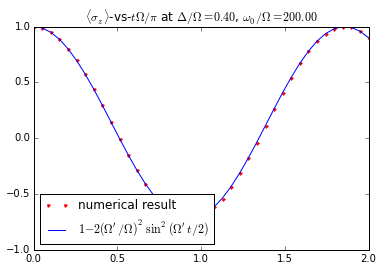

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
σz_expect = expect(sigmaz(), res)
plt.plot(ts*Ω/np.pi, σz_expect, 'r.', label='numerical result')
Ωp = (Ω**2+Δ**2)**0.5
plt.plot(ts*Ω/np.pi, 1-(Ω/Ωp)**2*2*np.sin(Ωp*ts/2)**2, 'b-',
         label=r'$1-2(\Omega^\prime/\Omega)^2\sin^2(\Omega^\prime t/2)$')
plt.title(r'$\langle\sigma_z\rangle$-vs-$t\Omega/\pi$ at '
          r'$\Delta/\Omega=%.2f$, $\omega_0/\Omega=%.2f$'%(Δ/Ω, ω0/Ω))
plt.ylim(-1,1)
plt.legend(loc=3);

# Benchmarks against Qutip

## Dense


<img src=basic_dense_benchmark.png style="width:100%">

## Sparse


<img src=basic_sparse_benchmark.png style="width:100%">

# TODO (i.e. HELP!?)
- Sparse matrices not fully supported
- Simplectic/Geometric ODE solvers
    - `qutip` uses a "handwavy" approach to preserving the norm. It works, but ...
- The "details"
    - built-in operators and states
    - visualization
    - others
- Make compilation faster
    - Compiling takes us ~6s. `qutip` does it in <1s.